In [15]:
import os
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sys.path.append(os.path.abspath('.'))
from utils import get_rolling_forecast, forecast_by_last_value, forecast_by_mean

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


# Chapter 5 Modeling an autoregressive process

## 5.1 Predicting the average weekly foot traffic in a retail store

Suppose that we want to forecast the average weekly foot traffic in a retail store so that the store manager can better manage the staff’s schedule. 

In [4]:
import pandas as pd
df = pd.read_csv('data/foot_traffic.csv')
df.head()      

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


By intuition, the process is not stationary.

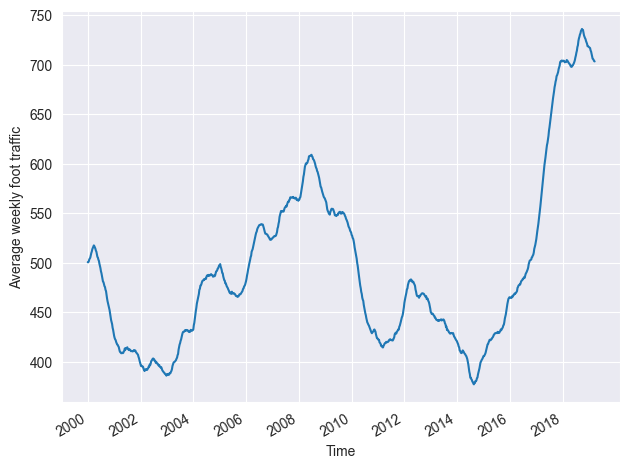

In [5]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])                                      
ax.set_xlabel('Time')                                            
ax.set_ylabel('Average weekly foot traffic')                     
 
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))    
 
fig.autofmt_xdate()                                              
plt.tight_layout()

We cannot reject the Null hypothesis that a unit root is present.

In [6]:
ADF_result = adfuller(df['foot_traffic'])     
print(f'ADF Statistic: {ADF_result[0]}')   
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.175888599924075
p-value: 0.6838808917896189


## 5.2 Defining the autoregressive process
We can express a general AR(p) model with an equation:
$$ y_t = C + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t  $$

Random walk is a special case of an AR(1) process where $\phi_1$ equals 1.

## 5.3 Finding the order of a stationary autoregressive process

In [7]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)

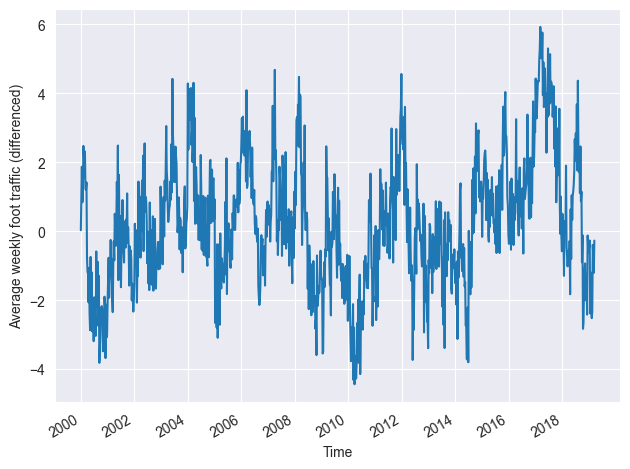

In [8]:
fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

We can reject the Null hypothesis that there's a unit root for `foot_traffic_diff`.

In [9]:
ADF_result = adfuller(foot_traffic_diff)
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -5.268231347422037
p-value: 6.3693176547815e-06


The ACF doesn't become non-signifcant abruptly after a certain lag. Therefore we know Ww do not have a random walk, nor do we have a MA process. Since it displays an exponential decay, we are probably having an autoregressive process.

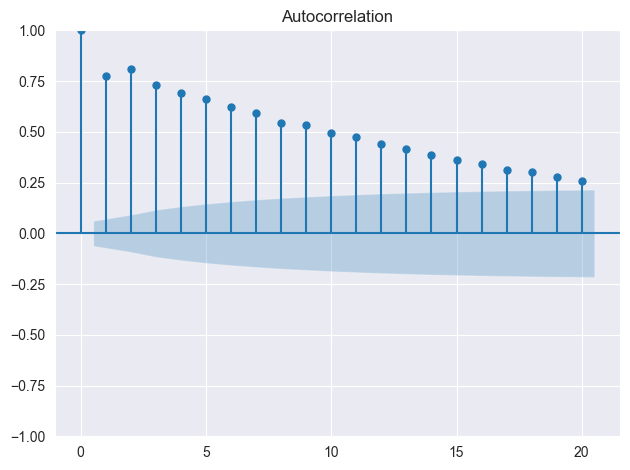

In [10]:
plot_acf(foot_traffic_diff, lags=20)
plt.tight_layout()

### 5.3.1 The partial autocorrelation function (PACF)
Suppose we have the following AR(2) process
$$ y_t = 0.33y_{t-1} + 0.50y_{t-2} $$

If we use the ACF to measure how $y_t$ relates to $t_{t-2}$, we must remove the $y_{t-2}$'s impact on $y_t$ by influencing $y_{t-1}$. That's why we need the PACF here.

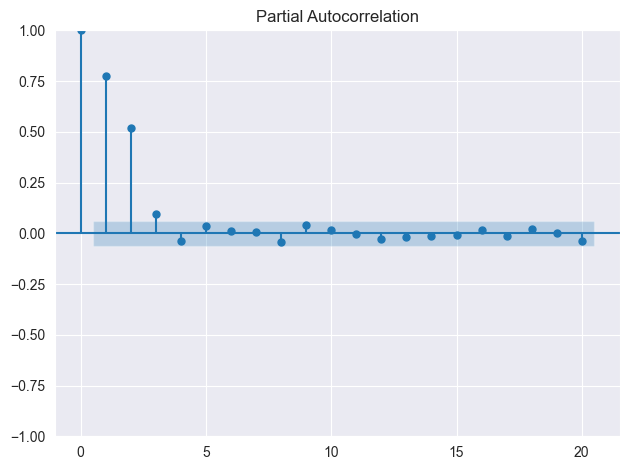

In [11]:
plot_pacf(foot_traffic_diff, lags=20)
plt.tight_layout()

## 5.4 Forecasting an auto progressive process

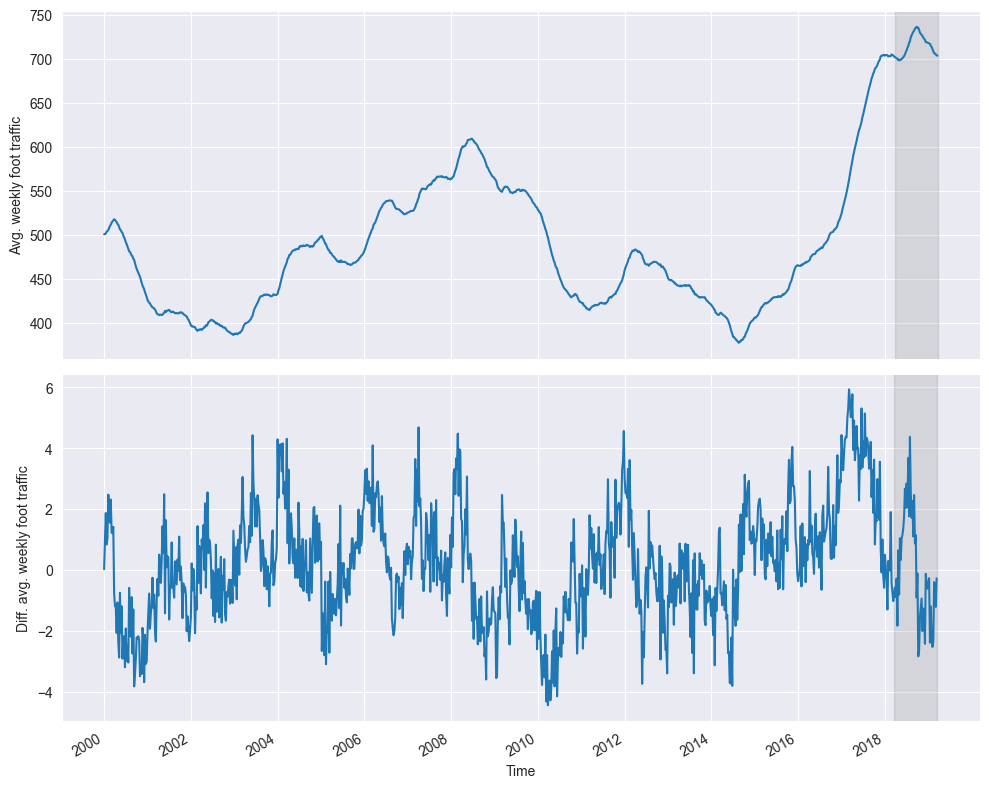

In [12]:
test_size = 52

df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})
train = df_diff[:-test_size]                                               
test = df_diff[-test_size:]   

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))
 
ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)
 
ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)
 
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
 
fig.autofmt_xdate()
plt.tight_layout()

In [13]:
def forecast_by_ar3(data, window):
    model = SARIMAX(data, order=(3,0,0))   
    res = model.fit(disp=False)
    predictions = res.get_prediction(0, len(data) + window - 1)
    return predictions.predicted_mean[-window:]

In [16]:
df_diff

,foot_traffic_diff
0,0.025651
1,0.904511
2,1.869114
3,0.836705
4,1.039848
...,...
994,-2.343634
995,-0.398483
996,-0.839213
997,-1.211415


In [18]:
DATA = df_diff['foot_traffic_diff'].tolist()
TRAIN_LEN = len(train)                      
HORIZON = len(test)                         
WINDOW = 1                                  

pred_mean = get_rolling_forecast(forecast_by_mean, DATA, TRAIN_LEN, HORIZON, WINDOW,)
pred_last_value = get_rolling_forecast(forecast_by_last_value, DATA, TRAIN_LEN, HORIZON, WINDOW)    
pred_AR = get_rolling_forecast(forecast_by_ar3, DATA, TRAIN_LEN, HORIZON, WINDOW)
 
test['pred_mean'] = pred_mean               
test['pred_last_value'] = pred_last_value   
test['pred_AR'] = pred_AR                  
 
test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


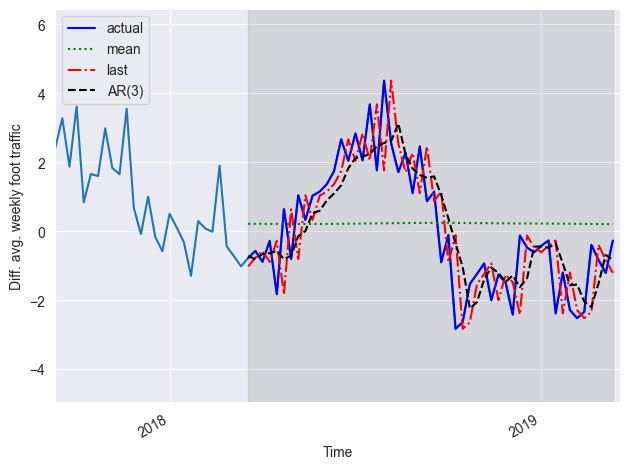

In [19]:
fig, ax = plt.subplots()
 
ax.plot(df_diff['foot_traffic_diff'])                       
ax.plot(test['foot_traffic_diff'], 'b-', label='actual')    
ax.plot(test['pred_mean'], 'g:', label='mean')              
ax.plot(test['pred_last_value'], 'r-.', label='last')       
ax.plot(test['pred_AR'], 'k--', label='AR(3)')           
 
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')
ax.axvspan(947, 998, color='#808080', alpha=0.2)
ax.set_xlim(920, 999)
plt.xticks([936, 988],[2018, 2019])
 
fig.autofmt_xdate()
plt.tight_layout()